In [3]:
# %matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-white')
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
#import bbi
from cooltools import snipping
import sys

In [6]:
def pileup_dots(cool_file,dot_file,exp_cool,resolution,flank,anchor_dist,anchor_flank,pileup_name):
    file_path=file.split('/')
    filename_tmp = file_path[-3]
    filename=filename_tmp.split('.')[0]
    print(filename)

    resolution=resolution
    flank = flank
    #resolution=sys.argv[4]
    hg38 = bioframe.fetch_chromsizes('hg38')
    chromsizes = bioframe.fetch_chromsizes('hg38')
    chromosomes = list(chromsizes.index)
    conditions = [filename]
    binsize = resolution

    cooler_paths = {    
    filename : cool_file,
    }

    long_names = {
    filename: filename,
    }

    pal = sns.color_palette('colorblind')
    colors = {
    filename: pal[0],
    }

    clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
    }

    anchor_dist = anchor_dist
    anchor_flank = anchor_flank

    sites = pd.read_table(dot_file)
    mid1=(sites['start1']+sites['end1'])/2
    mid2=(sites['start2']+sites['end2'])/2
    new_file=pd.DataFrame()
    new_file = pd.concat([sites['chrom1'],mid1,sites['chrom2'],mid2],axis=1)

    # "convergent" orientation of paired CTCF motifs
    # sites = sites[(sites['strand1'] == '+') & (sites['strand2'] == '-')] ## not working 
    new_file.columns=['chrom1','mid1','chrom2','mid2']
    print(len(new_file))
    new_file.head()
    supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

    snippet_flank = 240000

    windows1 = snipping.make_bin_aligned_windows(
    binsize, 
    new_file['chrom1'], 
    new_file['mid1'],
    flank_bp=snippet_flank)
    # windows1['strand'] = sites['strand1']
    windows2 = snipping.make_bin_aligned_windows(
    binsize, 
    new_file['chrom2'], 
    new_file['mid2'],
    flank_bp=snippet_flank)
    windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
    windows = snipping.assign_regions(windows, supports)
    windows = windows.dropna()
    windows.head()
    #stacks = {}
    piles = {}
    for cond in conditions:
        expected = pd.read_table(exp_cool)
        snipper = snipping.ObsExpSnipper(clrs[cond], expected)
        print(snipper)
        stack = snipping.pileup(windows, snipper.select, snipper.snip)
        #stacks[cond] = stack
        piles[cond] = np.nanmean(stack, axis=2)


    gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
    plt.figure(figsize=(6 * len(conditions), 6))

    opts = dict(
    vmin=-0.3,
    vmax=0.3,
    extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
    cmap='coolwarm'
    )

    for i, cond in enumerate(conditions):
        ax = plt.subplot(gs[i])
        img = ax.matshow(
            np.log10(piles[cond]), #piles[cond]),  
            **opts)
        ax.xaxis.tick_bottom()
        if i > 0:
            ax.yaxis.set_visible(False)
        plt.title(long_names[cond])

    ax = plt.subplot(gs[len(conditions)])
    plt.colorbar(img, cax=ax)
    plt.suptitle(f'Dot calls ({anchor_dist//1000} +/- {anchor_flank//1000})kb apart\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {len(windows)}')
    plt.savefig(pileup_name)
    

U54-ESC4DN-DSG-DpnII-R1-R2_hg38


/home/ba69w/tools/miniconda3/envs/cooler-env/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/home/ba69w/tools/miniconda3/envs/cooler-env/lib/python3.7/site-packages/ipykernel_launcher.py:69: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


835


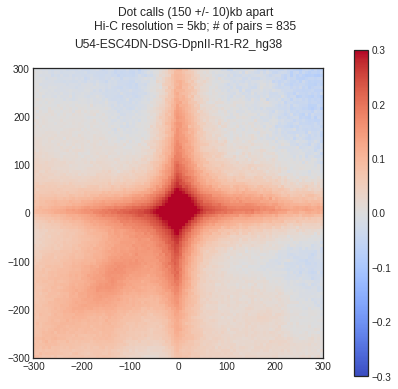

In [7]:
file ="/nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_deep/results/comb_replicates_coolers/U54-ESC4DN-DSG-DpnII-R1-R2_hg38.mapq_30.1000.mcool::/resolutions/5000"
dot_file = "/nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_deep/snakedots/comp_dots/U54_ESC4DN_FA_DpnII_R1_R2_hg38_uniq_comp_to_U54_ESC4DN_DSG_DpnII_R1_R2_hg38.txt"
exp_cool="/nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_deep/snakedots/U54-ESC4DN-DSG-DpnII-R1-R2_hg38/expected/U54-ESC4DN-DSG-DpnII-R1-R2_hg38.mapq_30.1000.mcool.5000.cis.expected"

pileup_dots(file,dot_file,exp_cool,5000,300000,150000,10000,"aaa.pdf")